In [1]:
!pip install transformers
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

from torch import cuda

In [2]:
device = "cuda" if cuda.is_available() else "cpu"


df = pd.read_csv("data.csv", index_col=False)
df_copy = df[["text", "super_strategy_label"]].copy()
df_copy.head()

,text,super_strategy_label
0,"The PressTV references in Wikipedia's ""Turkey-...",1
1,"If you have time, can you correct the titles?",3
2,I had really hoped to get some more opinions o...,6
3,"I modified it a bit, possibly vote to reopen?",4
4,Well the only plausible explanation was that y...,1


In [3]:
# Clean the text 
def normalise_text(text):
    text = text.strip()
    text = text.lower() # lowercase
    text = text.replace(r"\#","") # replaces hashtags
    text = text.replace(r"http\S+","URL")  # remove URL addresses
    text = text.replace(r"@","")
    text = text.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    text = text.replace(r"\#","")
    return text
df_copy.text = df_copy.text.apply(normalise_text)
df_copy.columns = ["text", "label"]
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5094 non-null   object
 1   label   5094 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 79.7+ KB


In [4]:
# keep 1/4 0 label
df_1 = df_copy.loc[df_copy.label > 0] 
df_0 = df_copy.loc[df_copy.label == 0]
df_0 = df_0.reset_index()
df_0 = df_0.sample(frac=0.25, replace=True, random_state=1)
train_df = pd.concat([df_1, df_0], ignore_index=True)
train_df = train_df.sample(frac=1)
train_df = train_df[["text", "label"]]
train_df.to_csv("clean_dataset.csv", index=False)
print(train_df)

                                                   text  label
243                                   please see <url>.      3
3135  you have listed it as no source but the author...      0
800   and since you are a well trusted user i am ask...      4
3305  that was a nice pic you put up in the civil wa...      0
1707  it's not explicit, but it seems like you want ...      4
...                                                 ...    ...
3258                              this sounds familiar.      0
1018  thank you for getting to all those wikiproject...      7
2467  have you tried asking on the distutils-sig mai...      4
2074  isn't it better to use the appropriate `select...      1
3290           does view source give you the same code?      0

[3562 rows x 2 columns]


In [5]:
# find max length
def get_text_len(text):
    return len(text.split(" "))
max_len = max(train_df.text.apply(get_text_len))
max_len

89

In [6]:
MAX_LEN = 100
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-05
CLASS_SIZE = 8

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [7]:
class PDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        text = str(self.data.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.label[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [8]:
train_size = 0.8
train_dataset = train_df.sample(frac=train_size, random_state=200)
test_dataset= train_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(train_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = PDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = PDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (3562, 2)
TRAIN Dataset: (2850, 2)
TEST Dataset: (712, 2)


In [9]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [10]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained("bert-base-uncased",return_dict=False)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, CLASS_SIZE)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [11]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [12]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [13]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _ % 1000 == 0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct * 100)/nb_tr_examples 
            print(f"Training Loss per 1000 steps: {loss_step}")
            print(f"Training Accuracy per 1000 steps: {accu_step}%")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct * 100)/nb_tr_examples}%')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct * 100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}%")
    print("===========================")

    return epoch_loss, epoch_accu


In [14]:
from pandas import DataFrame
epochs_loss_history = []
epochs_accu_history = []
for epoch in range(EPOCHS):
    epoch_loss, epoch_accu = train(epoch)
    epochs_loss_history.append(epoch_loss)
    epochs_accu_history.append(epoch_accu)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training Loss per 1000 steps: 2.0276291370391846
Training Accuracy per 1000 steps: 6.25%
The Total Accuracy for Epoch 0: 49.1578947368421%
Training Loss Epoch: 1.4548758348273165
Training Accuracy Epoch: 49.1578947368421%
Training Loss per 1000 steps: 0.9762874245643616
Training Accuracy per 1000 steps: 68.75%
The Total Accuracy for Epoch 1: 68.59649122807018%
Training Loss Epoch: 0.9300150399268007
Training Accuracy Epoch: 68.59649122807018%
Training Loss per 1000 steps: 1.1390187740325928
Training Accuracy per 1000 steps: 62.5%
The Total Accuracy for Epoch 2: 78.94736842105263%
Training Loss Epoch: 0.6562623730834636
Training Accuracy Epoch: 78.94736842105263%
Training Loss per 1000 steps: 0.706458568572998
Training Accuracy per 1000 steps: 75.0%
The Total Accuracy for Epoch 3: 88.28070175438596%
Training Loss Epoch: 0.4322126451983798
Training Accuracy Epoch: 88.28070175438596%
Training Loss per 1000 steps: 0.6520106196403503
Training Accuracy per 1000 steps: 68.75%
The Total Accura

In [15]:
df = DataFrame(epochs_loss_history, columns=['bert_epochs_loss_history'])
df["bert_epochs_accu_history"] = epochs_accu_history
df.to_csv("bert_history.csv", index=False)

In [16]:
from sklearn.metrics import f1_score, confusion_matrix

def valid(model, testing_loader):
    model.eval()
    tr_loss = 0
    n_correct = 0 
    n_wrong = 0
    total = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    f1 = 0.0
    targets_list = []
    big_idx_list = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            targets_list.extend(targets.tolist())
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            big_idx_list.extend(big_idx.tolist())
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%100 == 0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct * 100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}%")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct * 100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}%")
    f1 = f1_score(targets_list, big_idx_list, average='macro')
    confusion_mat = confusion_matrix(targets_list, big_idx_list, normalize='all')

    return epoch_accu, f1, confusion_mat


Validation Loss per 100 steps: 0.00020265279454179108
Validation Accuracy per 100 steps: 100.0%


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation Loss Epoch: 1.0163302041808984
Validation Accuracy Epoch: 84.8314606741573%
Accuracy on test data: 84.8314606741573
Marco F1 score: 0.7192671387347549
Confusion Matrix:  [[0.11235955 0.03370787 0.         0.00702247 0.00561798 0.
  0.         0.        ]
 [0.02808989 0.0997191  0.         0.00140449 0.00983146 0.00140449
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.00140449 0.        ]
 [0.00421348 0.00140449 0.         0.21910112 0.01123596 0.
  0.00140449 0.        ]
 [0.00702247 0.00702247 0.         0.00983146 0.28792135 0.
  0.00140449 0.        ]
 [0.         0.         0.         0.00140449 0.00280899 0.00561798
  0.         0.        ]
 [0.00140449 0.00421348 0.         0.00280899 0.00561798 0.
  0.05758427 0.        ]
 [0.         0.         0.         0.         0.00140449 0.
  0.         0.06601124]]


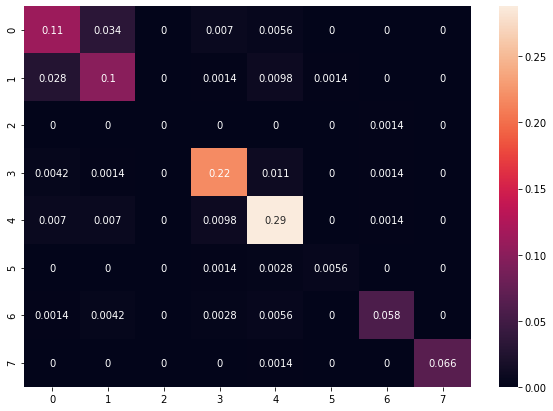

In [17]:
acc, f1, confusion_mat = valid(model, testing_loader)
print(f"Accuracy on test data: {acc}")
print(f"Marco F1 score: {f1}")
print("Confusion Matrix: ", confusion_mat)

!pip install seaborn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_mat, index = [i for i in "01234567"],
                  columns = [i for i in "01234567"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('bert_712_confusion_matrix.png', dpi=400)

In [18]:
output_model_file = 'pytorch_bert_model.bin'
output_vocab_file = 'vocab_bert_model.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

All files saved


In [19]:
# human annotated testset
df = pd.read_csv("testset_human.csv", index_col=False)
df.head()

,text,label
0,"if you have time, can you correct the titles?",3.0
1,i had really hoped to get some more opinions o...,6.0
2,"i modified it a bit, possibly vote to reopen?",6.0
3,well the only plausible explanation was that y...,1.0
4,is that what indeed occurred?,1.0


In [20]:
testing_set = PDataset(df, tokenizer, MAX_LEN)
testing_loader = DataLoader(testing_set, **test_params)

Validation Loss per 100 steps: 0.0007925463723950088
Validation Accuracy per 100 steps: 100.0%


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation Loss Epoch: 4.093509748336926
Validation Accuracy Epoch: 53.84615384615385%
Accuracy on test data: 53.84615384615385
Marco F1 score: 0.5146995161701045
Confusion Matrix:  [[0.13461538 0.07692308 0.         0.         0.01923077 0.01923077
  0.         0.        ]
 [0.01923077 0.07692308 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.03846154 0.01923077 0.03846154 0.
  0.         0.        ]
 [0.         0.         0.         0.11538462 0.03846154 0.
  0.         0.        ]
 [0.         0.05769231 0.         0.03846154 0.09615385 0.01923077
  0.03846154 0.        ]
 [0.01923077 0.01923077 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.03846154 0.
  0.01923077 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.05769231]]


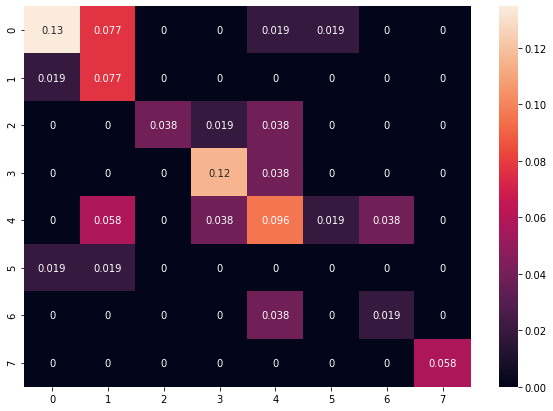

In [21]:
acc, f1, confusion_mat = valid(model, testing_loader)
print(f"Accuracy on test data: {acc}")
print(f"Marco F1 score: {f1}")
print("Confusion Matrix: ", confusion_mat)

df_cm = pd.DataFrame(confusion_mat, index = [i for i in "01234567"],
                  columns = [i for i in "01234567"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('bert_50_confusion_matrix.png', dpi=400)